In [1]:
import os
import math

from typing import Annotated, List
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_core.tools import tool
from langgraph.graph import START, END
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [3]:
llm = ChatOpenAI(
    model="gpt-4o", 
    temperature=0.0, 
    max_tokens=1000
)

In [4]:
prompt_agent_supervisor = """
Voce é um professor de matematica com mais de 30 anos de experiencia.

<INSTRUCOES>
- Voce vai receber perguntas de matematica dos alunos do 3 ano do ensino medio.
- resolva a equação realizando operação por operação.
- Para cada operação voce devera chamar a tool especifica.
- Voce deve responder apenas perguntas relacionadas a matematica.
- A resposta deve conter a explicação de cada operação ate chegar no resultado.
<\INSTRUCOES>

<IMPORTANTE>
Nunca realize os calculos, sempre utilize as tools para realizalos.
<\IMPORTANTE>

"""


In [5]:
@tool
def tool_add(
    a: Annotated[float, Field(description="Numero 1")],
    b: Annotated[float, Field(description="Numero 2")]
) -> float:
	"""Soma dois numeros"""
	return a + b

@tool
def tool_multiply(
    a: Annotated[float, Field(description="Numero 1")],
    b: Annotated[float, Field(description="Numero 2")]
) -> float:
	"""Multiplica dois numeros"""
	return a * b

@tool
def tool_divide(
    a: Annotated[float, Field(description="Numero 1")],
    b: Annotated[float, Field(description="Numero 2")]
) -> float:
	"""Divide dois numeros"""
	return a / b

@tool
def tool_subtract(
    a: Annotated[float, Field(description="Numero 1")],
    b: Annotated[float, Field(description="Numero 2")]
) -> float:
	"""Subtrai dois numeros"""
	return a - b

@tool
def tool_sqrt(
    x: Annotated[float, Field(description="Número do qual se deseja obter a raiz quadrada")]
) -> float:
    """Calcula a raiz quadrada de um número"""
    return math.sqrt(x)

@tool
def tool_power(
    base: Annotated[float, Field(description="Número base")],
    exponent: Annotated[float, Field(description="Expoente ao qual a base será elevada")]
) -> float:
    """Eleva um número (base) a um expoente"""
    return math.pow(base, exponent)

@tool
def tool_sum(
    values: Annotated[List[float], Field(description="Lista de números a serem somados")]
) -> float:
    """Calcula o somatório de uma lista de números"""
    return sum(values)


tools = [tool_add, tool_subtract,tool_multiply, tool_divide, tool_sqrt, tool_power, tool_sum]

In [6]:
def agent_supervisor(state: MessagesState):
    
    messages = state['messages']

    llm_with_tools = llm.bind_tools(tools)

    response = llm_with_tools.invoke([SystemMessage(content=prompt_agent_supervisor)] + messages)
    
    return {"messages": [response]}



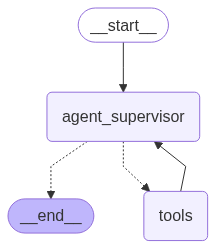

In [7]:
builder = StateGraph(MessagesState)

builder.add_node("agent_supervisor", agent_supervisor)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent_supervisor")
builder.add_conditional_edges("agent_supervisor", tools_condition)

builder.add_edge(START, "agent_supervisor")

builder.add_edge("tools", "agent_supervisor")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [8]:
# pergunta = {"messages": [HumanMessage(content="quanto é 2.3 + 2?")]}
# pergunta = {"messages": [HumanMessage(content="quanto é (2.3 + (2 / 2))^2?")]}
pergunta = {"messages": [HumanMessage(content="Professor, poderia me ajudar a calcular o coeficiente de correlação entre as variáveis X e Y nos seguintes pares de valores: X = [1, 2, 3, 4, 5, 5] e Y = [2, 3, 6, 7, 8, 12], e também me explicar como interpretar o resultado?")]}

for chunk in graph.stream(pergunta):
    pretty_print_messages(chunk)

Update from node agent_supervisor:


================================== Ai Message ==================================

Claro! O coeficiente de correlação de Pearson é uma medida que indica a força e a direção da relação linear entre duas variáveis. Ele varia de -1 a 1, onde:

- 1 indica uma correlação positiva perfeita,
- -1 indica uma correlação negativa perfeita,
- 0 indica que não há correlação linear.

Para calcular o coeficiente de correlação, utilizamos a fórmula:

\[ r = \frac{n(\sum{XY}) - (\sum{X})(\sum{Y})}{\sqrt{[n\sum{X^2} - (\sum{X})^2][n\sum{Y^2} - (\sum{Y})^2]}} \]

Onde:
- \( n \) é o número de pares de dados,
- \( \sum{XY} \) é a soma do produto dos pares de dados,
- \( \sum{X} \) e \( \sum{Y} \) são as somas dos valores de X e Y, respectivamente,
- \( \sum{X^2} \) e \( \sum{Y^2} \) são as somas dos quadrados dos valores de X e Y, respectivamente.

Vamos calcular passo a passo. Primeiro, precisamos calcular as somas necessárias. Vou começar calculando \(\sum{X}\), \(\s

In [9]:
pergunta = {"messages": [HumanMessage(content="Professor, qual a capital do Brasil?")]}

for chunk in graph.stream(pergunta):
    pretty_print_messages(chunk)

Update from node agent_supervisor:


================================== Ai Message ==================================

Eu sou especializado em matemática e estou aqui para ajudar com questões relacionadas a essa área. Se você tiver alguma dúvida matemática, ficarei feliz em ajudar!


